<!DOCTYPE html>
<html>
<head>
    <style>
        table {
            width: 50%;
            border-collapse: collapse;
            margin: 20px auto;
        }
        th, td {
            border: 1px solid #dddddd;
            text-align: left;
            padding: 15px;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>
<center>
<img src="https://hcmut.edu.vn/img/nhanDienThuongHieu/bk_name_en.png" alt="hcmut logo"/>

<table>
    <tr>
        <th>Role</th>
        <th>Name</th>
        <th>ID</th>
    </tr>
    <tr>
        <td>Institution</td>
        <td>Ho Chi Minh University of Technology</td>
        <td></td>
    </tr>
    <tr>
        <td>Mentor</td>
        <td>Vo hung</td>
        <td></td>
    </tr>
    <tr>
        <td>Actor</td>
        <td>Doan Tran Cao Tri</td>
        <td>2010733</td>
    </tr>
    <tr>
        <td></td>
        <td>A</td>
        <td>2</td>
    </tr>
    <tr>
        <td></td>
        <td>B</td>
        <td>2</td>
    </tr>
</table>

</center>
</body>
</html>


### Setup and Import

In [ ]:
!pip install datasets evaluate -q
!pip install jiwer -q
!pip install -U accelerate -q
!pip install -U transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [ ]:
ds = ds["train"].train_test_split(test_size=0.3)
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280>,
 'text': 'a cartoon sheep is holding a hot dog'}

### Preprocessing

In [ ]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)
processor

GitProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "GitProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: BertTokenizerFast(name_or_path='microsoft/git-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False,

Processor for both inputs are images and texts. Which using CLIPImageProcessor for images and BertTokenizerFast for texts

In [ ]:
def transforms(example_batch):
  images = [x for x in example_batch["image"]]
  captions = [x for x in example_batch["text"]]
  inputs = processor(images=images, text=captions, padding="max_length")
  inputs.update({"labels": inputs["input_ids"]})
  return inputs

In [ ]:
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

### Base model

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [ ]:
model

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
import numpy as np

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
       return logits
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

In [ ]:
from evaluate import load
import torch

wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted, labels = preprocess_logits_for_metrics(logits, labels)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer

# Training

In [ ]:
train_ds, test_ds

(Dataset({
     features: ['image', 'text'],
     num_rows: 583
 }),
 Dataset({
     features: ['image', 'text'],
     num_rows: 250
 }))

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    save_total_limit=5,
    evaluation_strategy="epoch",
    # eval_steps=50,
    save_strategy="epoch",
    # save_steps=50,
    logging_strategy="epoch",
    # logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Wer Score
0,9.158200,7.557196,74.681159
1,6.862600,5.745167,21.407076
2,4.977800,3.866543,11.232310
4,1.366500,0.636763,4.313299
5,0.377500,0.142961,1.605712
6,0.088700,0.047337,0.849531
8,0.022900,0.030367,0.506394
9,0.017700,0.029864,0.462063
10,0.013300,0.029311,1.227195
12,0.009100,0.030604,1.867860


KeyboardInterrupt: ignored

# Prediction

In [ ]:
import torch
from PIL import Image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

a blue and white object floating in the air


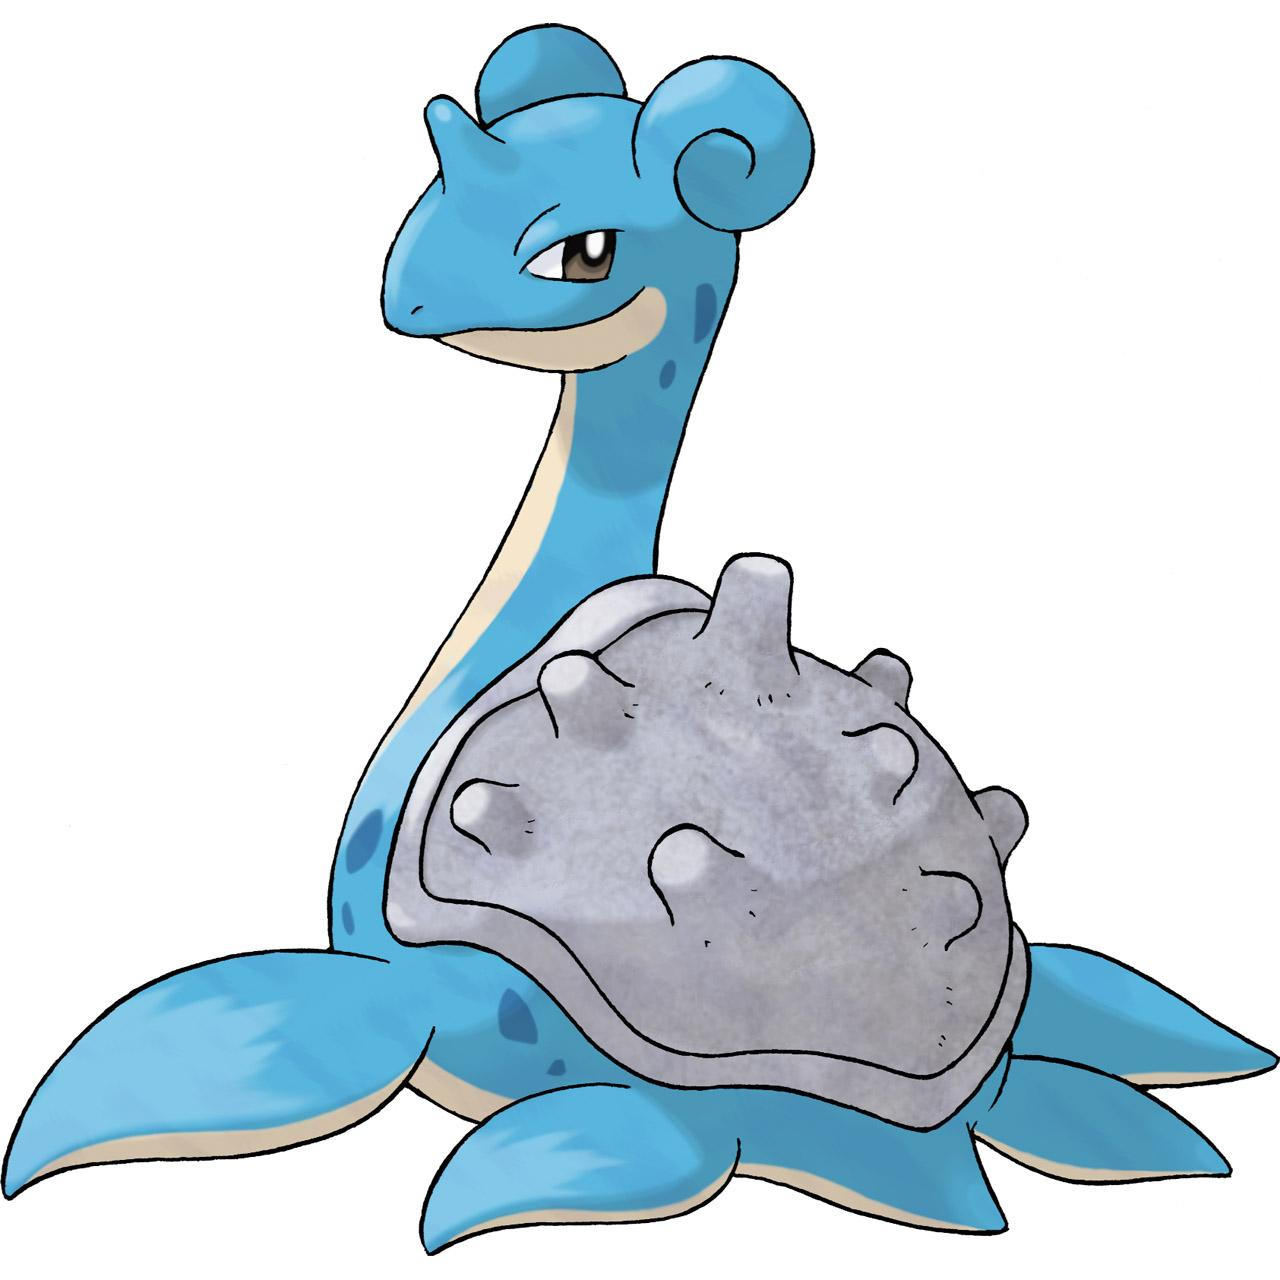

In [ ]:
def run(image):
  inputs = processor(images=image, return_tensors="pt").to(device)
  generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_caption

image = Image.open("pokemon.png")
print(run(image))
image

# Save model

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the save path within your Drive
save_path = '/content/drive/MyDrive/NLP-Thầy Hùng/ModelHub/BERT-pokemon-gen2.ckpt'

# Save the model
trainer.save_model(save_path)